In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import scipy.stats as stats
import pandas as pd
import pickle
import os
from sklearn.linear_model import LinearRegression, Ridge

regions = {0: 'imgs', 1: 'caudate', 2: 'cerebellum', 3: 'frontal_lobe', 4: 'insula', 5: 'occipital_lobe', 6: 'parietal_lobe', 7: 'putamen', 8: 'temporal_lobe', 9: 'thalamus'}
root = '/media/leelabsg-storage1/yein/research/test/'
age_diff_groups = {}

In [135]:
def bias_correction(true, pred):
    reg = LinearRegression().fit(true.reshape(-1, 1), pred)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]

    corrected_pred = (pred - beta_0) / beta_1
    return corrected_pred
    
def bias_correction_with_penalty(true, pred, alpha=1.0):
    true = np.array(true).reshape(-1, 1)
    pred = np.array(pred)
    
    # Ridge regression with regularization parameter alpha
    reg = Ridge(alpha=alpha).fit(true, pred)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]
    
    corrected_pred = (pred - beta_0) / beta_1
    
    return corrected_pred



def pickle_load(root, cn=False, alpha=1.0):
    map = {v: {'pred_ages': [], 'true_ages': []} for _, v in regions.items()}

    # true_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickel_path = os.path.join(root, str(cv_num), 'true_ages.pkl')
        if os.path.exists(pickel_path):
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file)  # cv-split size의 dict (region: age_lists)  # age_lists length: 630
                for region, age_list in curr_cv.items():
                    if cn == False:
                        map[region]['true_ages'] = age_list
                    else:
                        map[region]['true_ages'].extend(age_list)
    
    # pred_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickle_path = os.path.join(root, str(cv_num), 'pred_ages.pkl')
        if os.path.exists(pickle_path):
            with open(pickle_path, 'rb') as file:
                curr_cv = pickle.load(file)
                for region, age_list in curr_cv.items():
                    if cn == False:
                        map[region]['pred_ages'].append(age_list)
                    else:
                        map[region]['pred_ages'].extend(age_list)
    # 평균
    if cn == False:
        for region, _ in map.items():
            map[region].setdefault('corrected_pred_ages', [])
            pred_ages_lists = map[region]['pred_ages']
            for pred in pred_ages_lists:
                true = map[region]['true_ages']
                # corrected_pred = bias_correction_with_penalty(true, pred, alpha)
                corrected_pred = bias_correction(np.array(true), np.array(pred))
                map[region]['corrected_pred_ages'].append(corrected_pred)
            pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
            map[region]['pred_ages'] = pred_avg_age

            corrected_pred_ages_lists = map[region]['corrected_pred_ages']
            corrected_pred_avg_age = [sum(values) / len(values) for values in zip(*corrected_pred_ages_lists)]
            map[region]['corrected_pred_ages'] = corrected_pred_avg_age

            print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))

    else:
        for region, age_list in map.items():
            pred = np.array(map[region]['pred_ages'])
            true = np.array(map[region]['true_ages'])
            map[region]['corrected_pred_ages'] = bias_correction_with_penalty(true, pred, alpha)
            print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']), len(map[region]['corrected_pred_ages']))

    
    # if cn == False:
    #     for region, _ in map.items():
    #         pred_ages_lists = map[region]['pred_ages']
    #         pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
    #         map[region]['pred_ages'] = pred_avg_age

           
    # # bias corrected pred age
    # for region, age_list in map.items():
    #     print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']))
    #     pred = np.array(map[region]['pred_ages'])
    #     true = np.array(map[region]['true_ages'])
    #     map[region]['corrected_pred_ages'] = bias_correction_with_penalty(true, pred)

    print("=" * 30)
    return map          

def age_dist_plot(region, cn, mci, ad):
    plt.hist(cn[region]['true_ages'], bins=30, alpha=0.5, label='CN', density=True, edgecolor='black')
    plt.hist(mci[region]['true_ages'], bins=30, alpha=0.5, label='MCI', density=True, edgecolor='black')
    plt.hist(ad[region]['true_ages'], bins=30, alpha=0.5, label='AD', density=True, edgecolor='black')
    plt.title('Age Distribution by group')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def age_plot(data, region):
    true = data[region]['true_ages']
    pred = data[region]['pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def age_plot_corrected(data, region):
    true = data[region]['true_ages']
    pred = data[region]['corrected_pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Corrected Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def calculate_corrected_age_diff_avg(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(corrected_pred_ages - true_ages)

def age_diff_plot(age_diff_dict, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    age_diff_max = max(abs(max(age_diff_dict.values())), abs(min(age_diff_dict.values())))

    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=-age_diff_max, vmax=age_diff_max)

    for region, age_diff in age_diff_dict.items():
        color = cmap(norm(age_diff))
        ax.barh(region, age_diff, color=color)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('PAD (years)')

    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD)')
    plt.show()

# 예측 연령 차이 계산
def calculate_age_diff_avg(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(pred_ages - true_ages)

def calculate_age_diff_dist(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = calculate_corrected_age_diff_avg(data, region)

    plt.hist(corrected_pred_ages, bins=30, alpha=0.5, label='Predicted', density=True, edgecolor='black', color='red')
    plt.hist(true_ages, bins=30, alpha=0.5, label='True', density=True, edgecolor='black', color='grey')
    # plt.hist(diff, bins=30, alpha=0.5, label='Difference', density=True, edgecolor='black')
    plt.title('Age Difference Distribution')
    plt.xlabel('Age Difference')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    # 그룹별 색상 설정
    colors = {
        'CN': 'blue',
        'MCI': 'green',
        'AD': 'red'
    }

    bar_width = 0.2  # 막대의 너비
    index = np.arange(len(regions))  # 지역 인덱스

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_groups[group][region] for region in regions]
        bar_positions = index + i * bar_width
        ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group])

    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions)
    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD) by Group')
    ax.legend()
    plt.show()

# age distribution by group

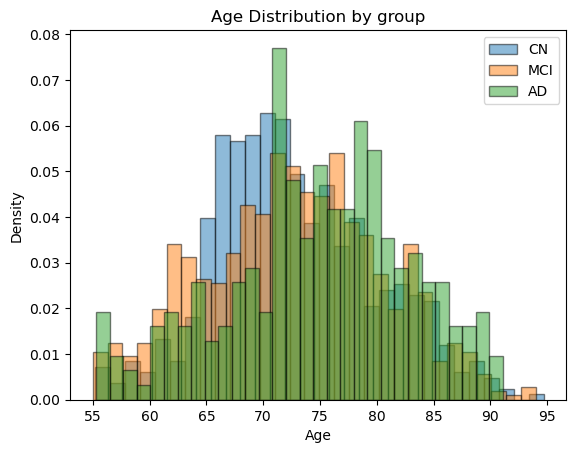

In [136]:
age_dist_plot('imgs', adni_cn_ages, adni_mci_ages, adni_ad_ages)

In [137]:
def age_describe_group(group):
    df = pd.read_csv(f'/media/leelabsg-storage1/yein/research/BAE/RegionBAE/data/adni_{group}_region.csv')
    print(df['age'].describe())


age_describe_group('cn')
age_describe_group('mci')
age_describe_group('ad')

count    630.000000
mean      72.764286
std        7.127740
min       55.200000
25%       67.600000
50%       71.750000
75%       77.450000
max       94.700000
Name: age, dtype: float64
count    812.000000
mean      72.603571
std        7.907687
min       55.000000
25%       67.000000
50%       72.800000
75%       78.100000
max       94.000000
Name: age, dtype: float64
count    261.000000
mean      74.829502
std        8.095389
min       55.300000
25%       70.400000
50%       75.200000
75%       80.300000
max       91.100000
Name: age, dtype: float64


In [138]:
# 그룹별 alpha 값 설정 (예시값, 실제 데이터에 따라 조정 필요)
alpha_cn = 0.5
alpha_mci = 1.2
alpha_ad = 10

cn_root = root + 'adni_cn_tf'
adni_cn_ages = pickle_load(cn_root, True, alpha_cn)
mci_root = root + 'adni_mci_tf'
adni_mci_ages = pickle_load(mci_root, False, alpha_mci)
ad_root = root + 'adni_ad_tf'
adni_ad_ages = pickle_load(ad_root, False, alpha_ad)

imgs 630 630 630
caudate 630 630 630
cerebellum 630 630 630
frontal_lobe 630 630 630
insula 630 630 630
occipital_lobe 630 630 630
parietal_lobe 630 630 630
putamen 630 630 630
temporal_lobe 630 630 630
thalamus 630 630 630
imgs 812 812 812
caudate 812 812 812
cerebellum 812 812 812
frontal_lobe 812 812 812
insula 812 812 812
occipital_lobe 812 812 812
parietal_lobe 812 812 812
putamen 812 812 812
temporal_lobe 812 812 812
thalamus 812 812 812
imgs 261 261 261
caudate 261 261 261
cerebellum 261 261 261
frontal_lobe 261 261 261
insula 261 261 261
occipital_lobe 261 261 261
parietal_lobe 261 261 261
putamen 261 261 261
temporal_lobe 261 261 261
thalamus 261 261 261


# CN

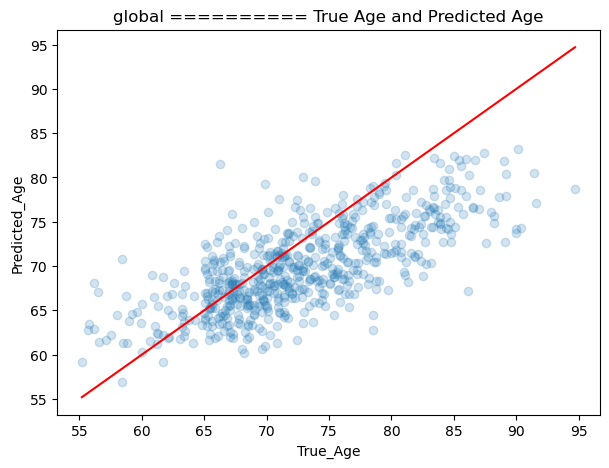

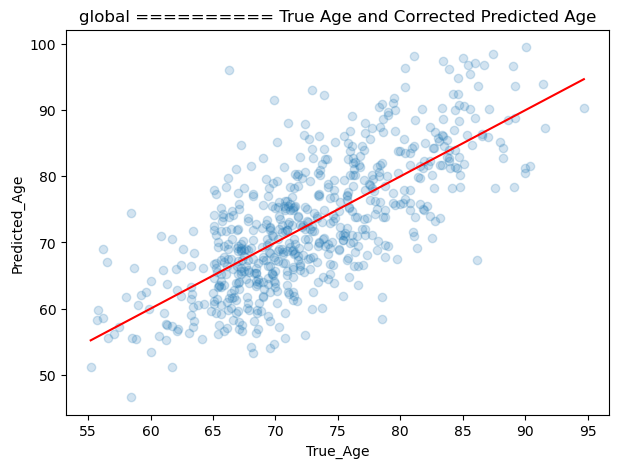

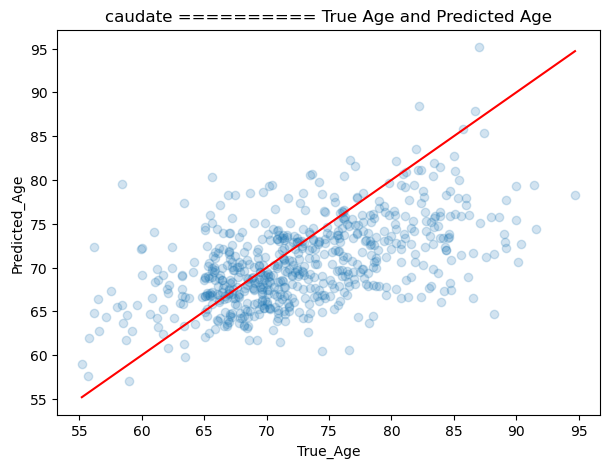

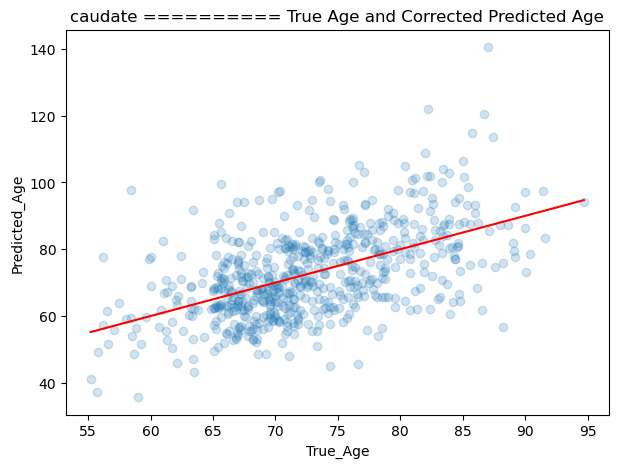

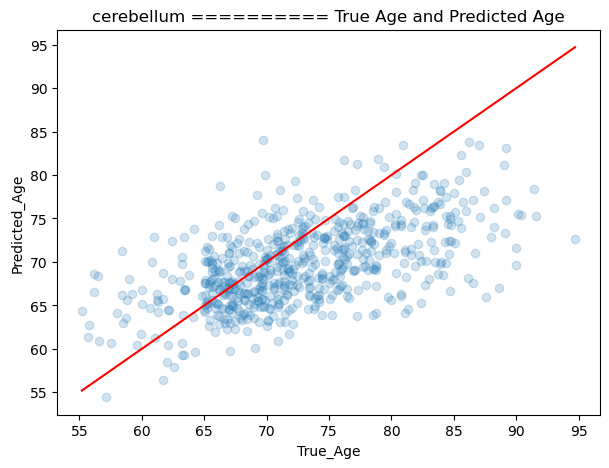

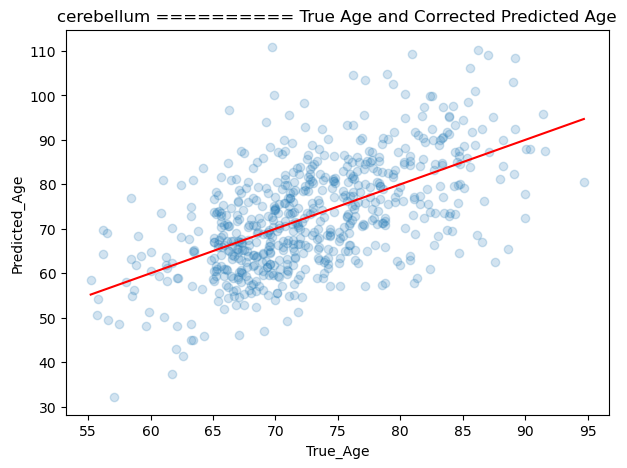

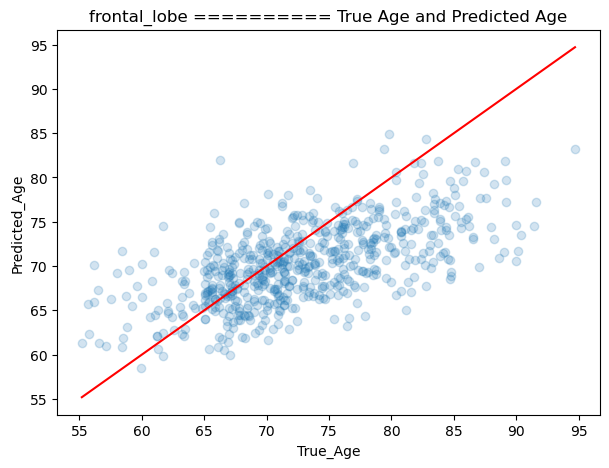

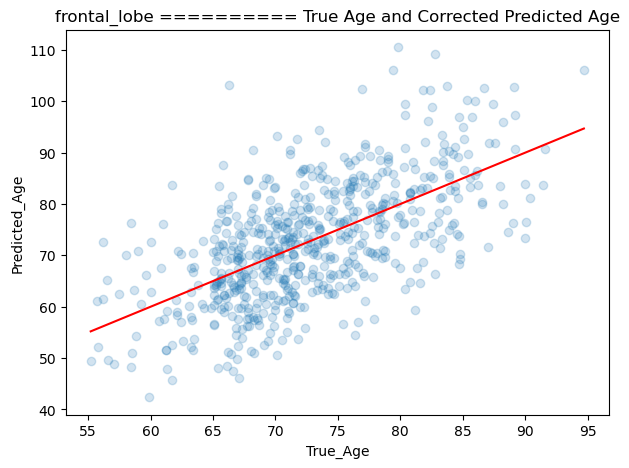

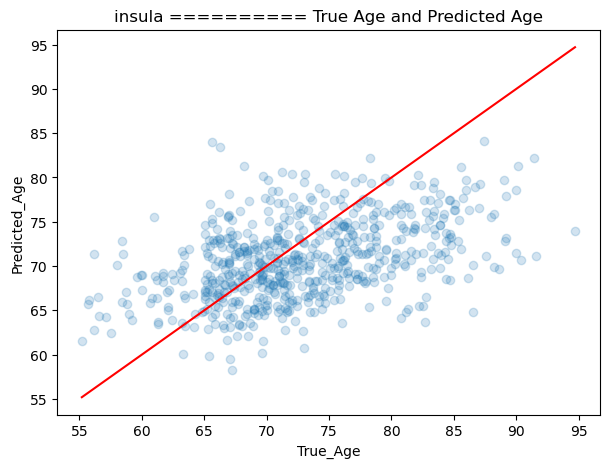

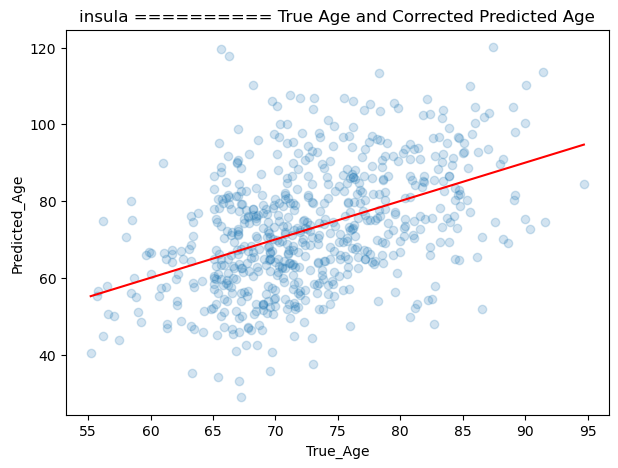

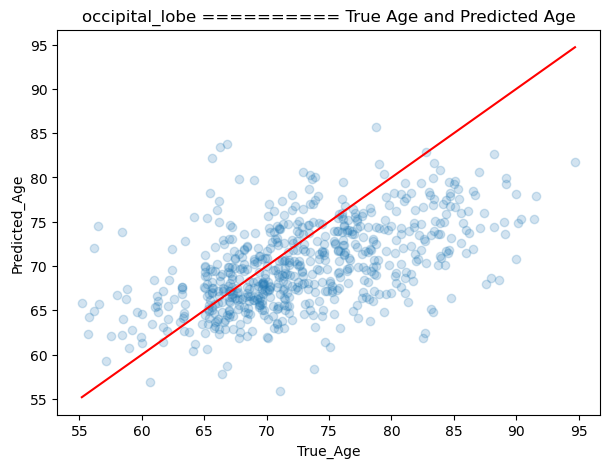

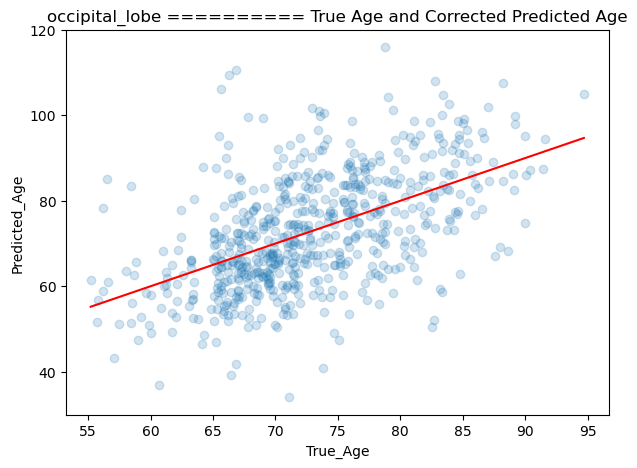

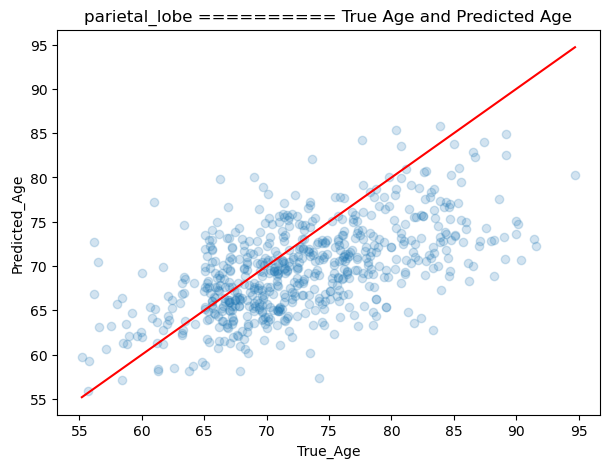

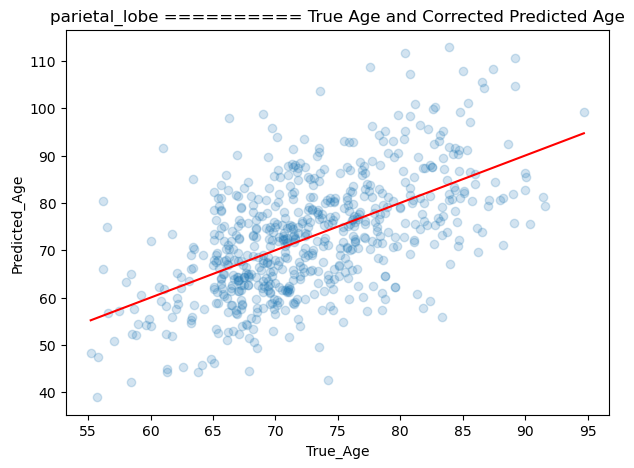

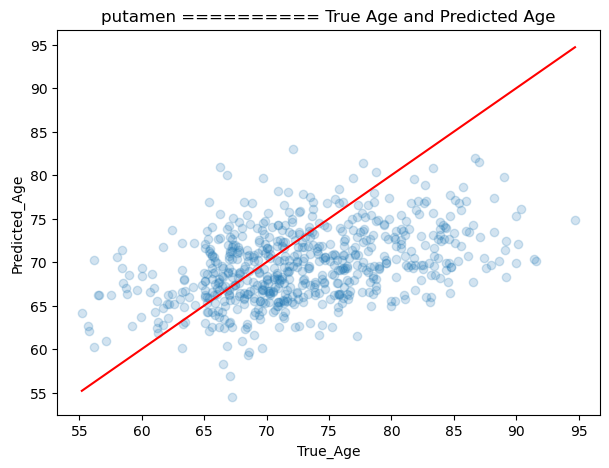

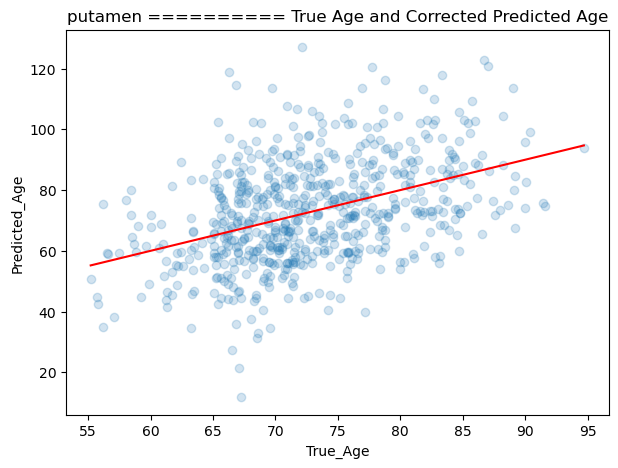

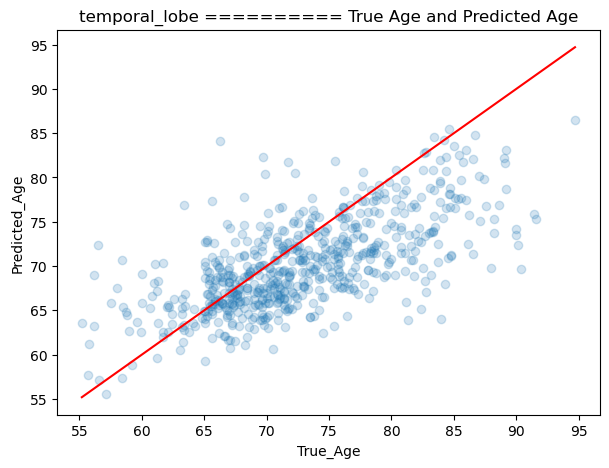

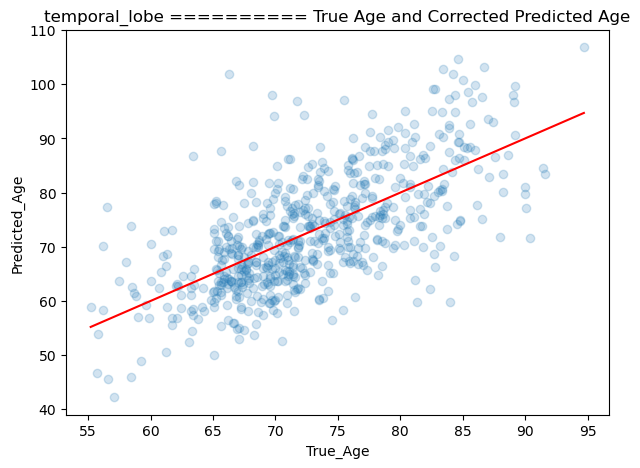

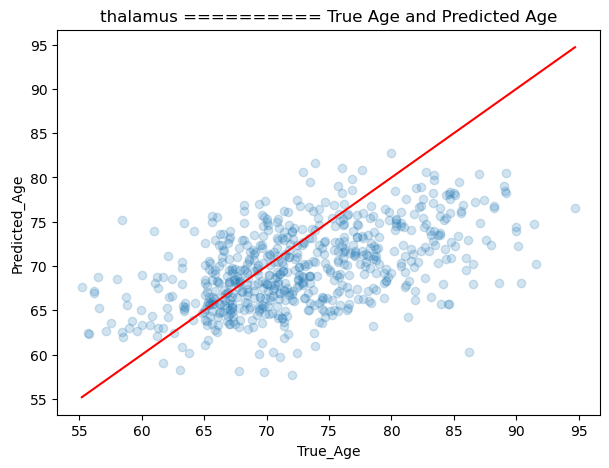

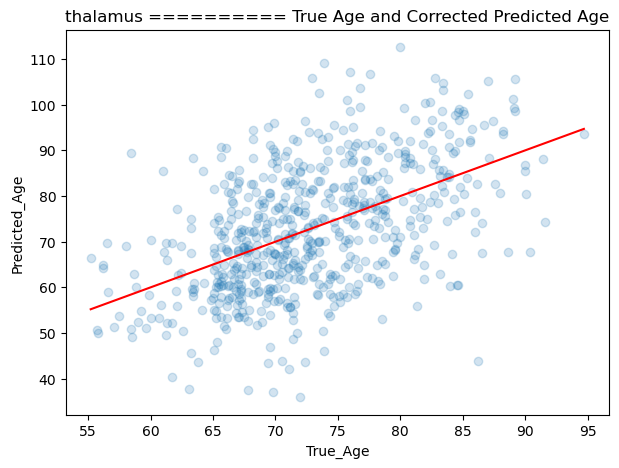

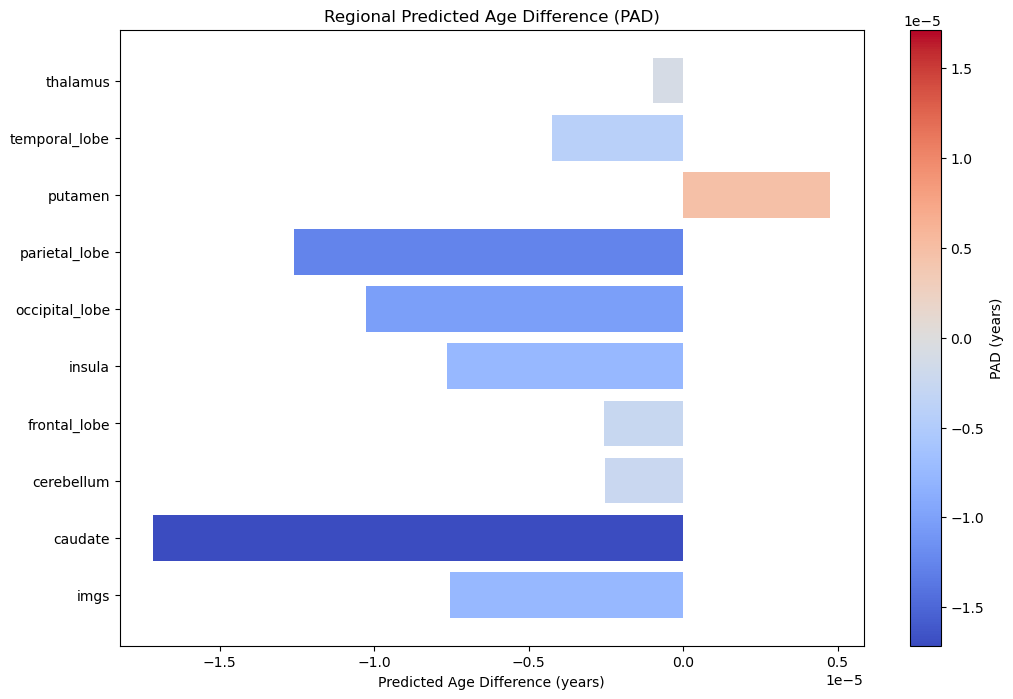

In [139]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    age_plot(adni_cn_ages, region)
    age_plot_corrected(adni_cn_ages, region)
    age_diff_dict[region] = calculate_corrected_age_diff_avg(adni_cn_ages, region)
    age_diff_groups['CN'][region] = age_diff_dict[region]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

In [140]:
# # 각 지역에 대한 예측 연령 차이 계산
# age_diff_dict = {}
# age_diff_groups['CN'] = dict()

# for key, region in regions.items():
#     age_plot(adni_cn_ages, region)
#     age_diff_dict[region] = calculate_age_diff_avg(adni_cn_ages,region)
#     age_diff_groups['CN'][region] = age_diff_dict[region]

# # 시각화
# age_diff_plot(age_diff_dict, regions.values())

# MCI

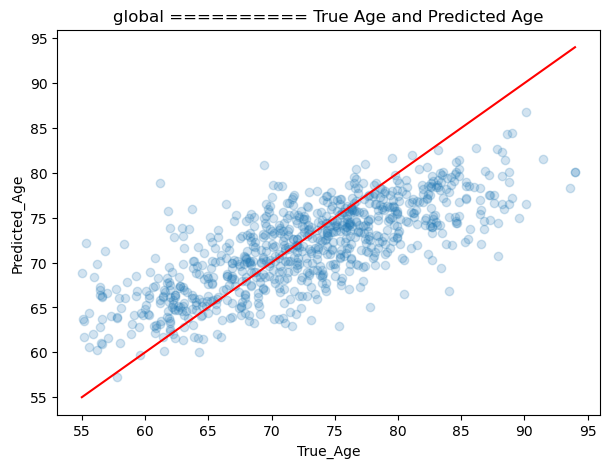

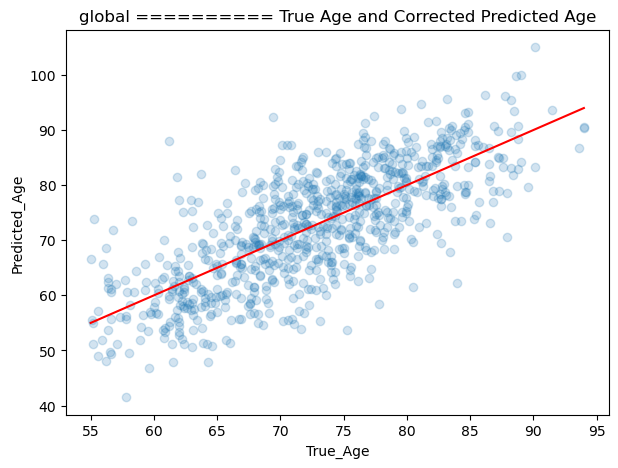

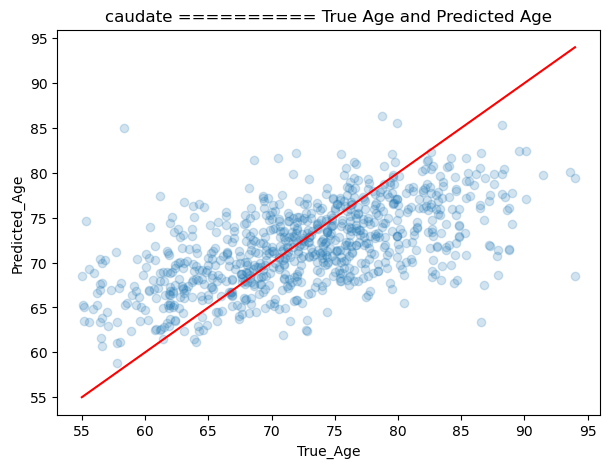

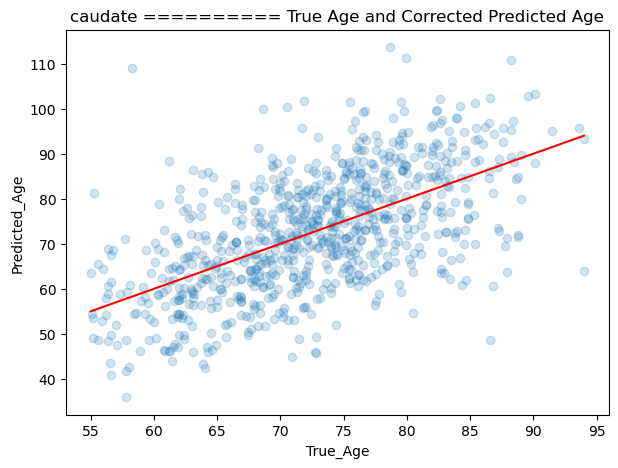

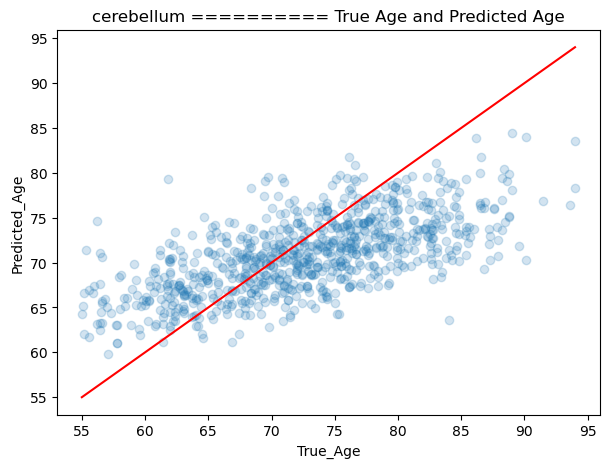

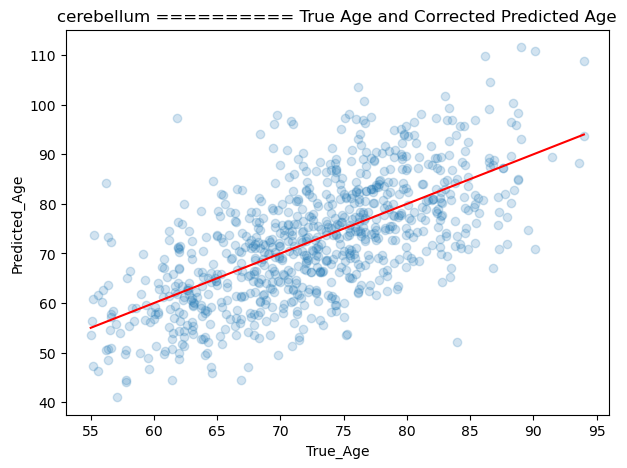

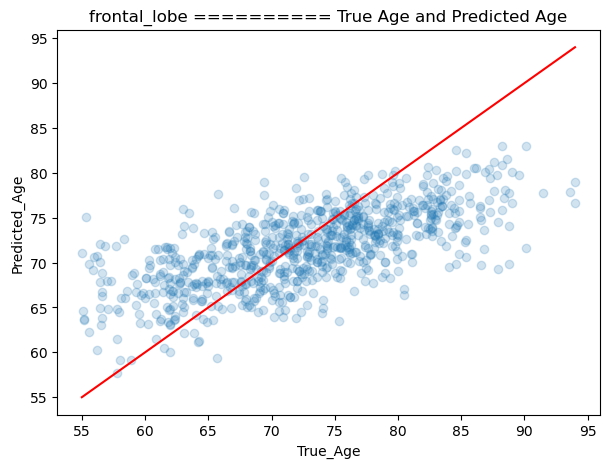

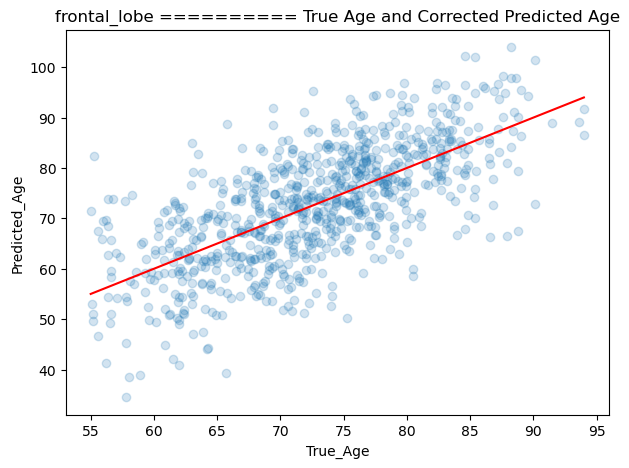

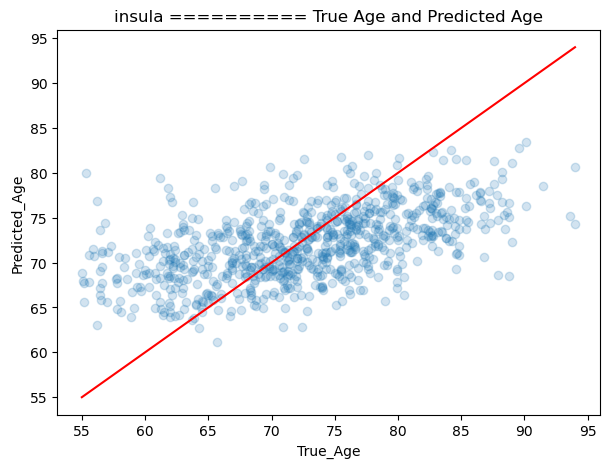

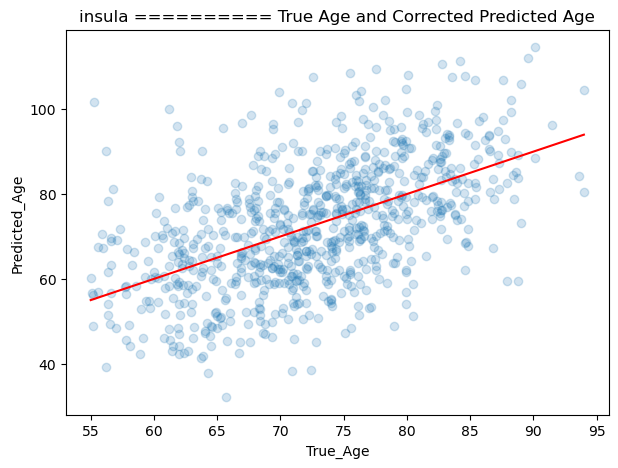

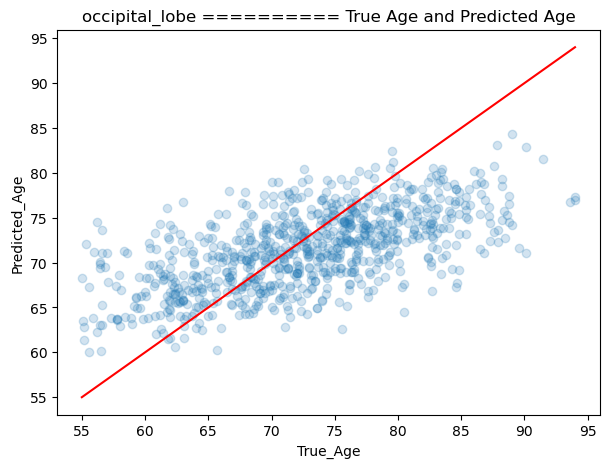

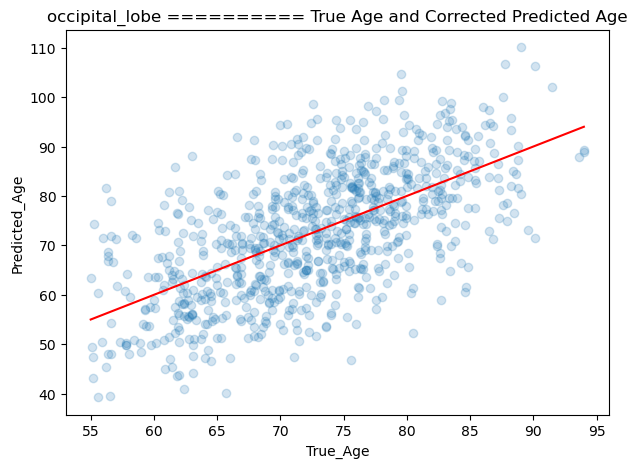

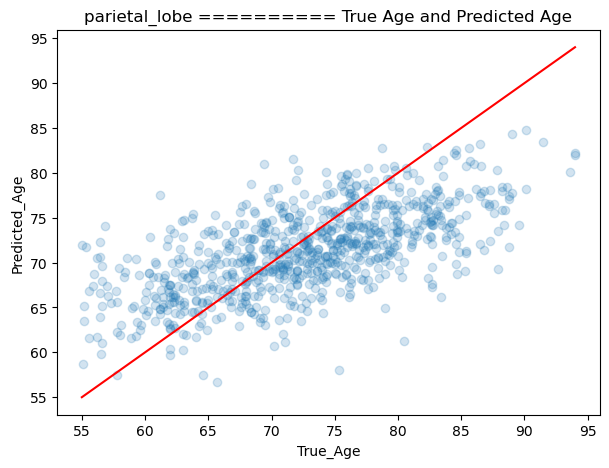

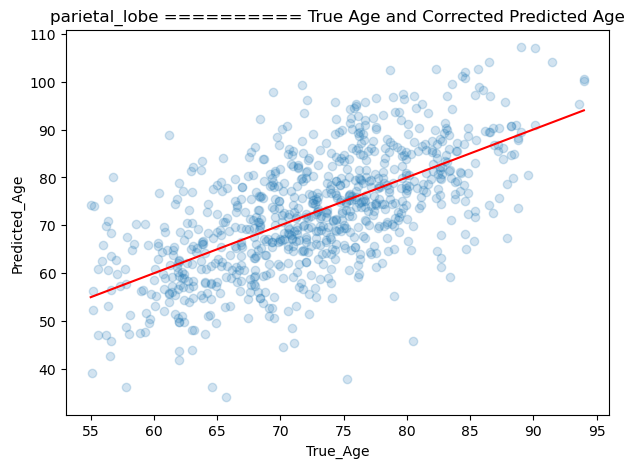

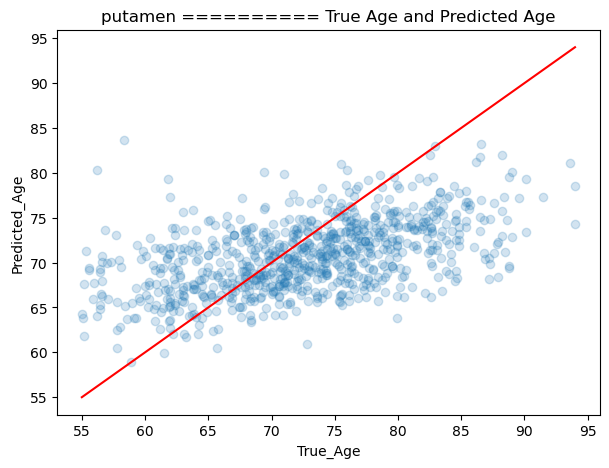

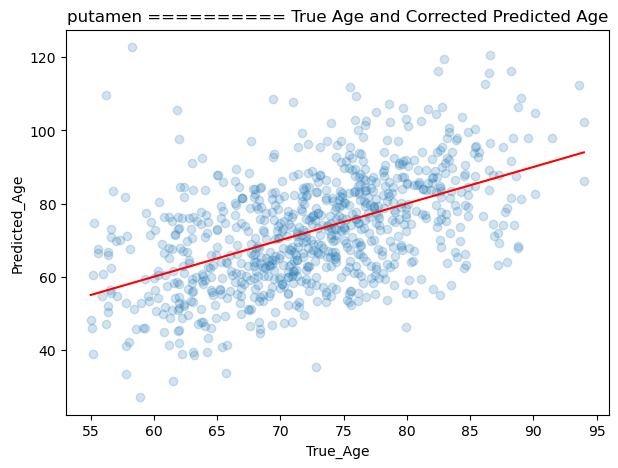

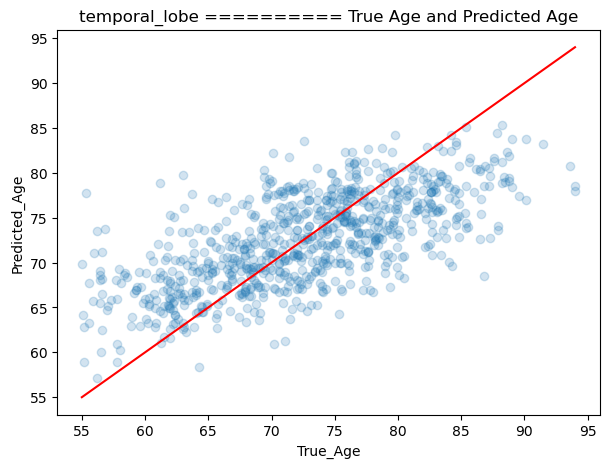

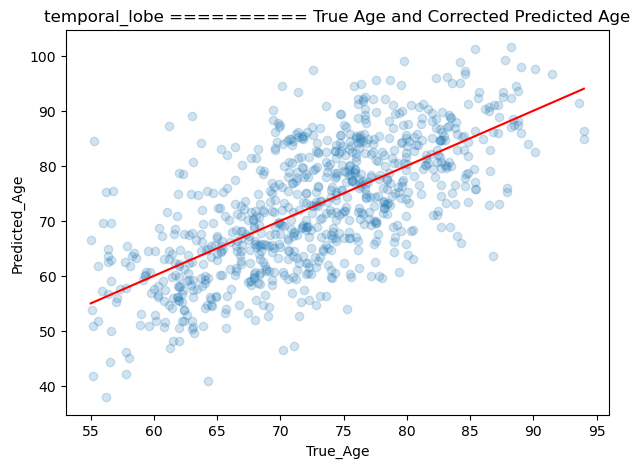

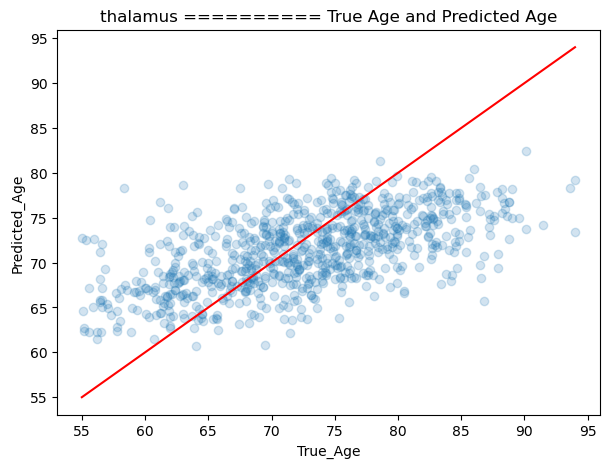

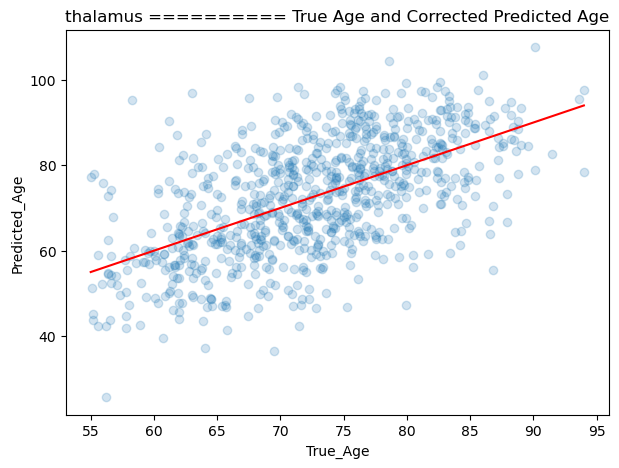

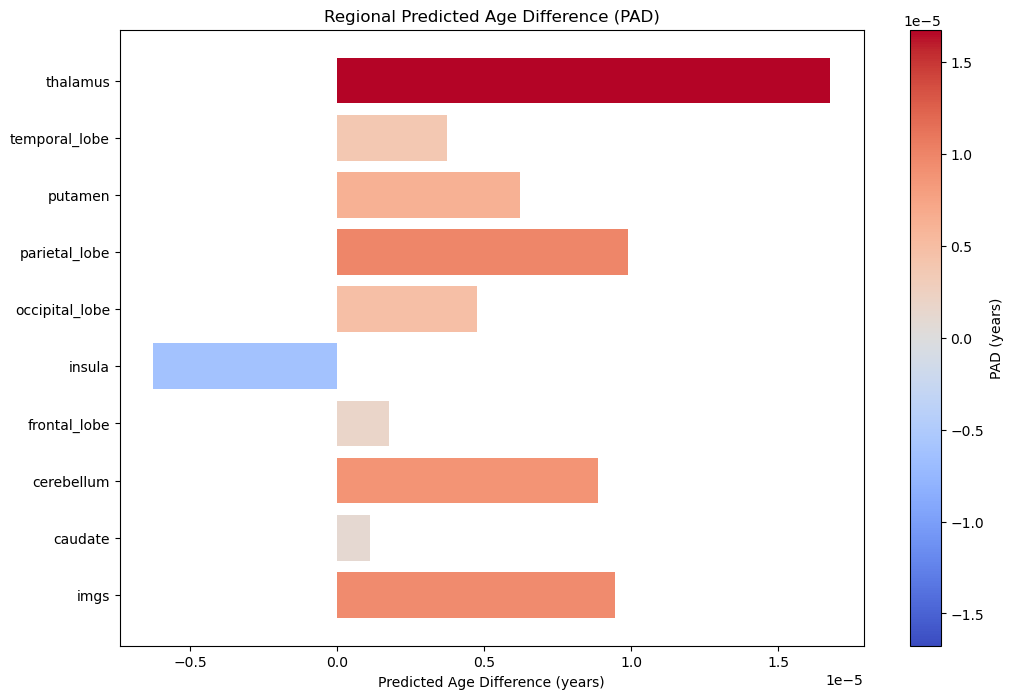

In [141]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['MCI'] = dict()

for key, region in regions.items():
    age_plot(adni_mci_ages, region)
    age_plot_corrected(adni_mci_ages, region)
    age_diff_dict[region] = calculate_corrected_age_diff_avg(adni_mci_ages,region)
    age_diff_groups['MCI'][region] = age_diff_dict[region]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# AD

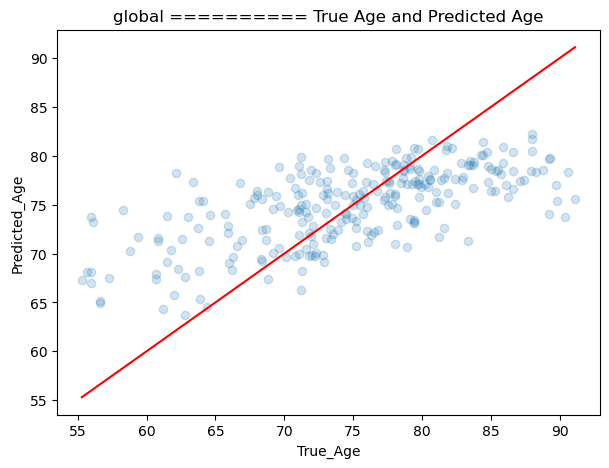

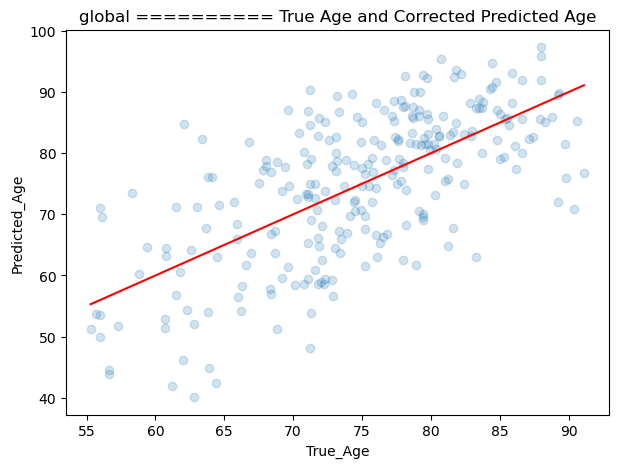

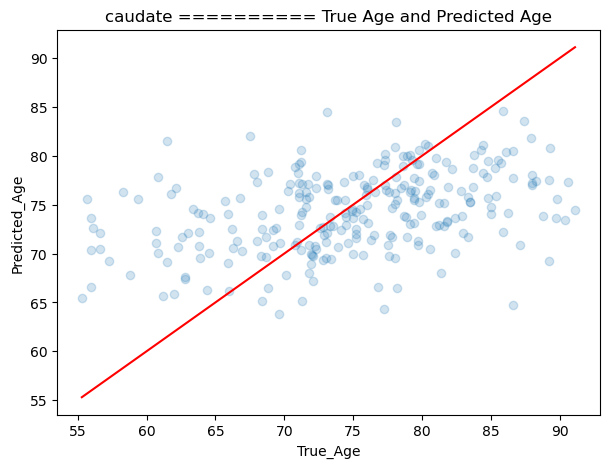

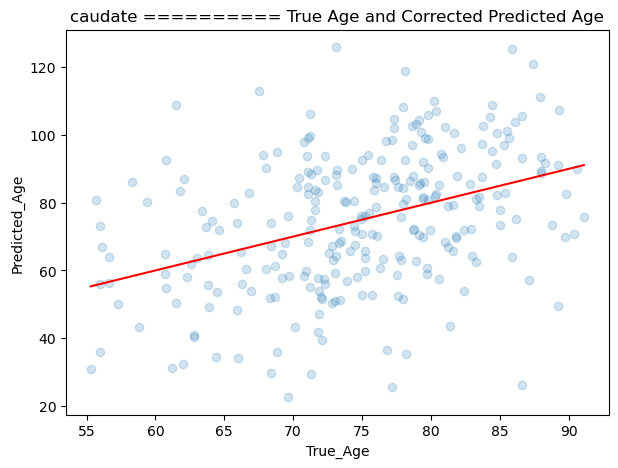

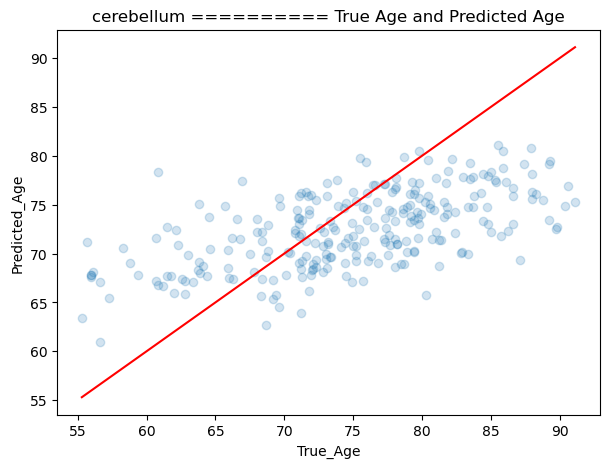

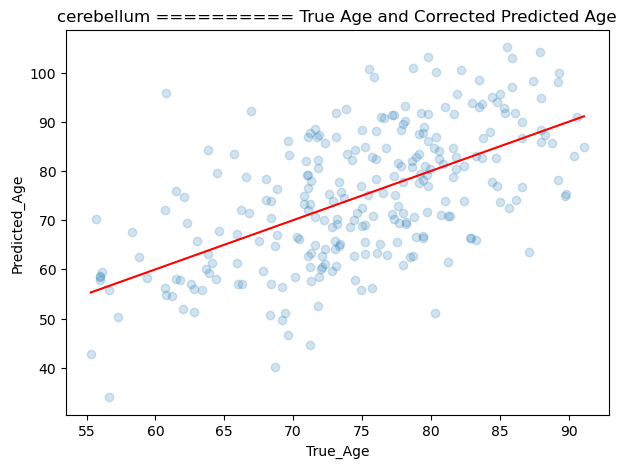

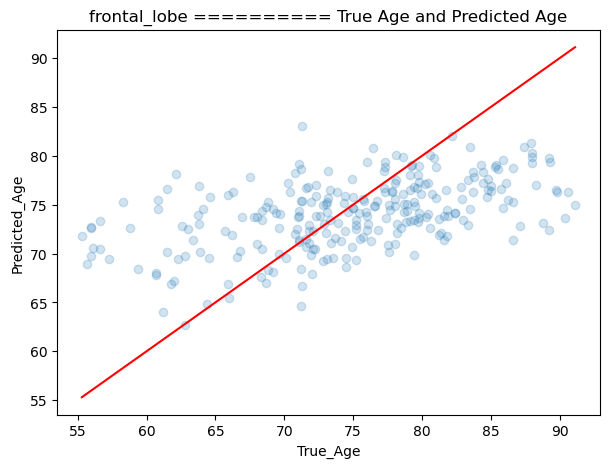

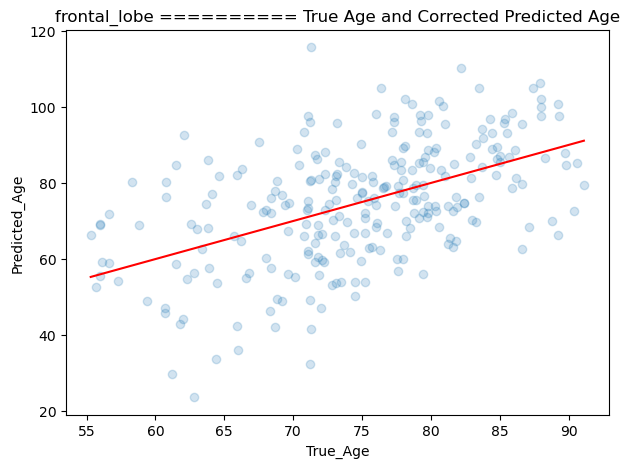

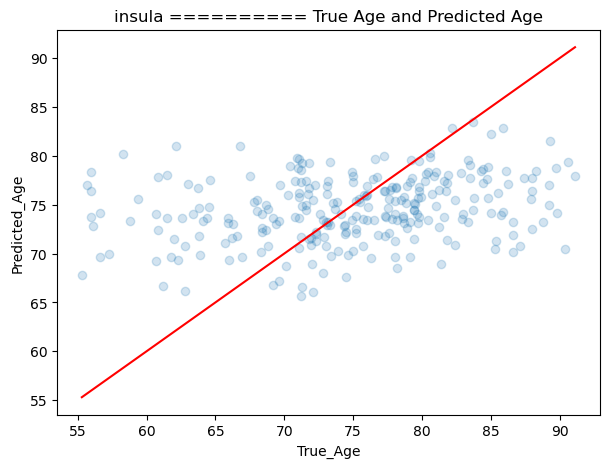

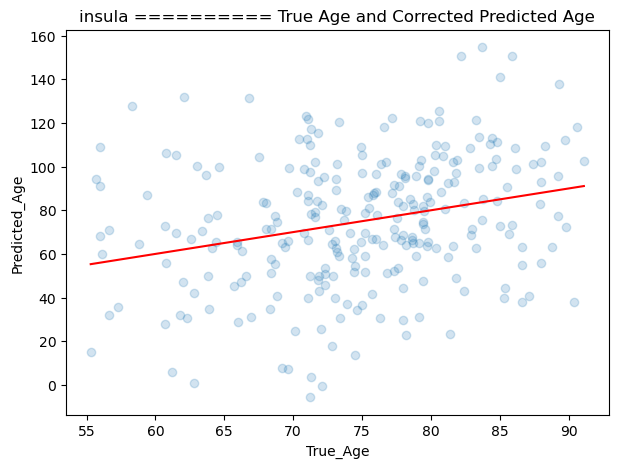

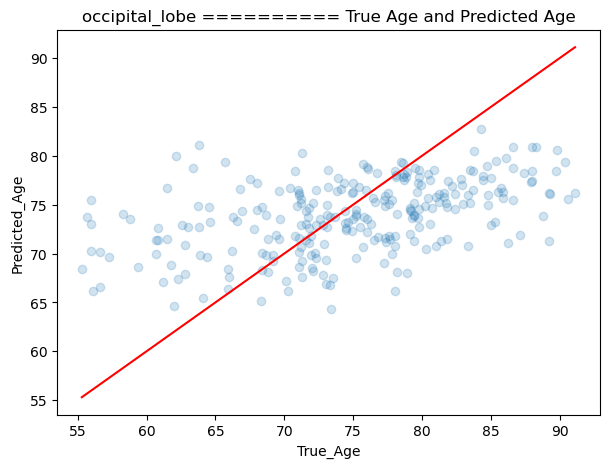

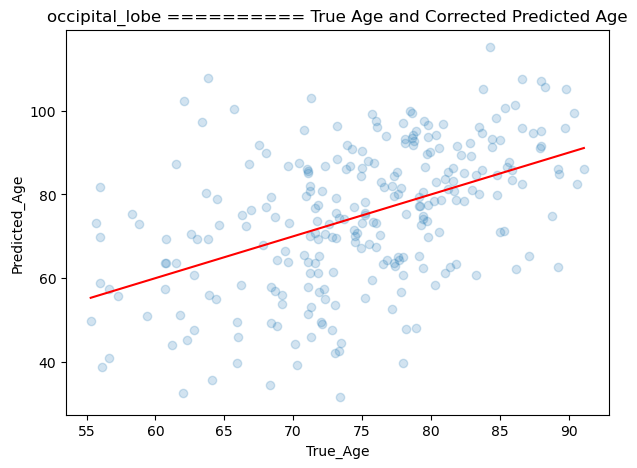

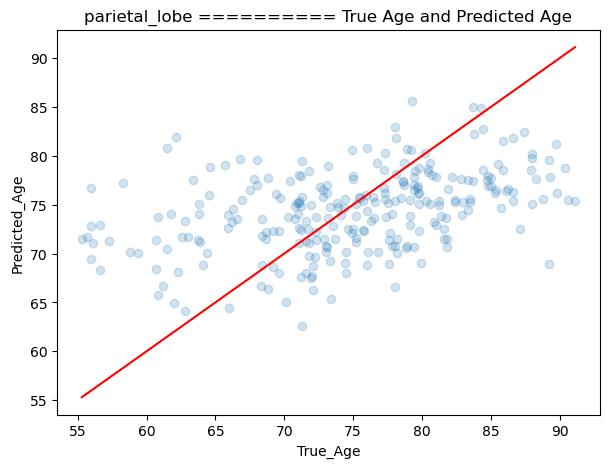

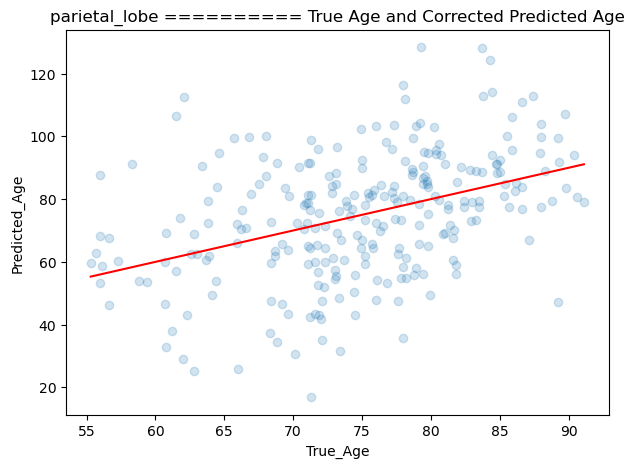

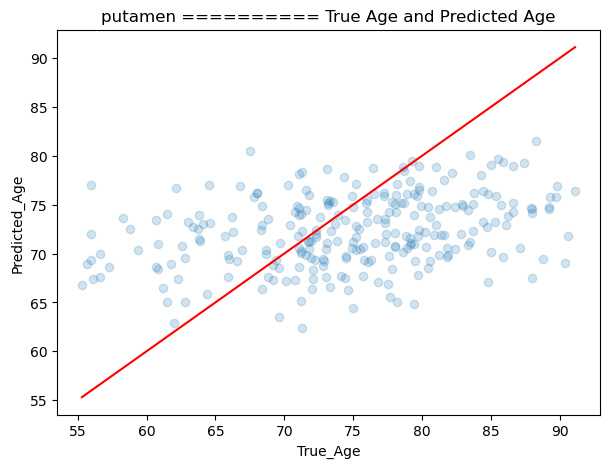

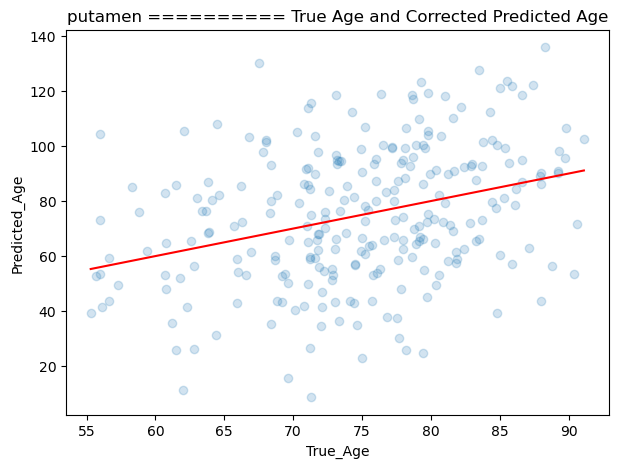

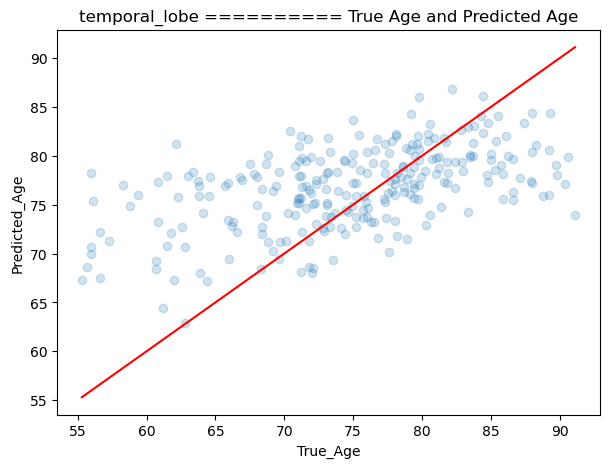

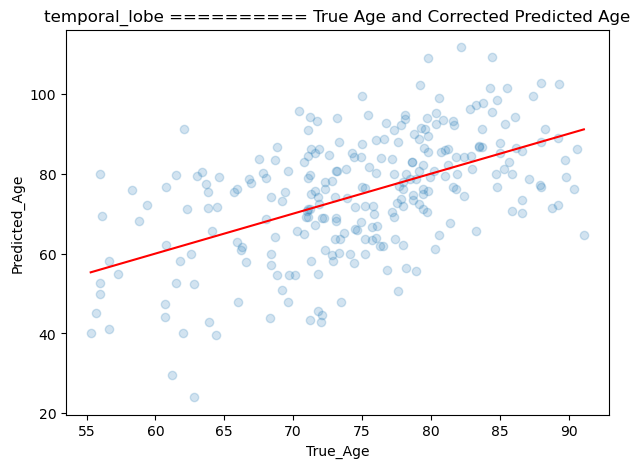

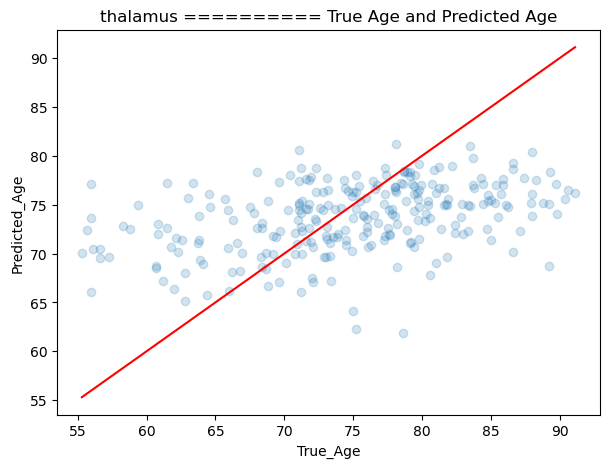

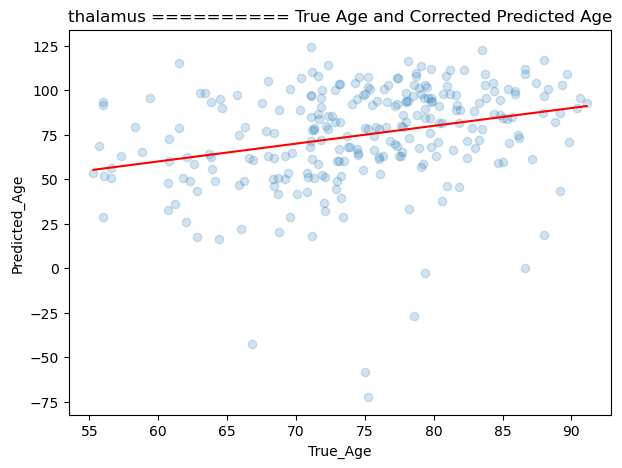

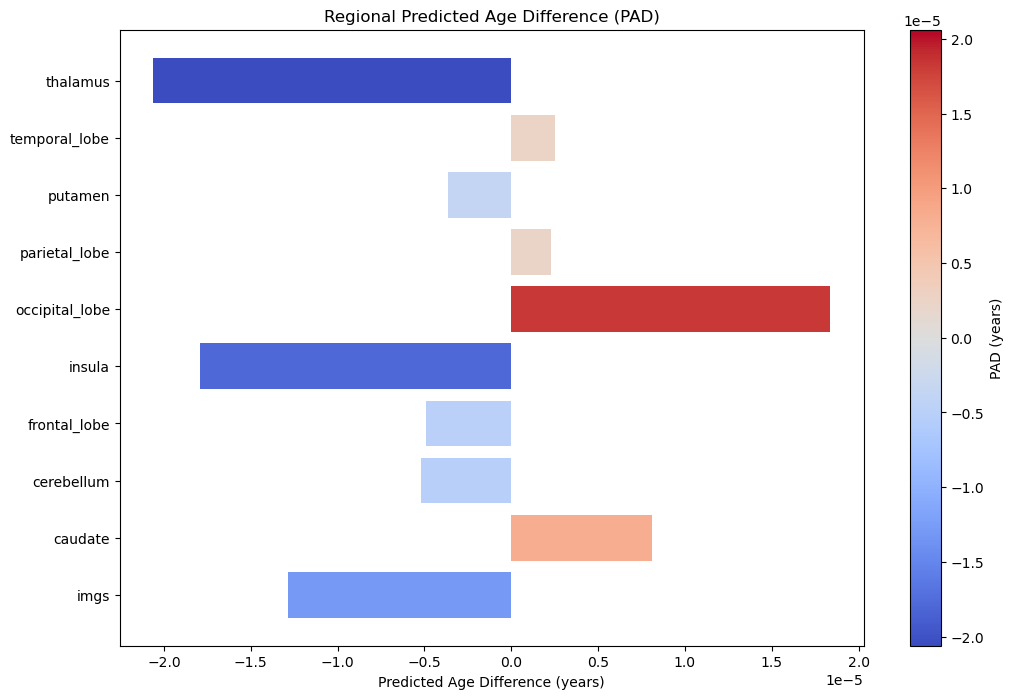

In [142]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups['AD'] = dict()

for key, region in regions.items():
    age_plot(adni_ad_ages, region)
    age_plot_corrected(adni_ad_ages, region)
    age_diff_dict[region] = calculate_corrected_age_diff_avg(adni_ad_ages,region)
    age_diff_groups['AD'][region] = age_diff_dict[region]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Regional Predicted Age Difference (PAD) by Group

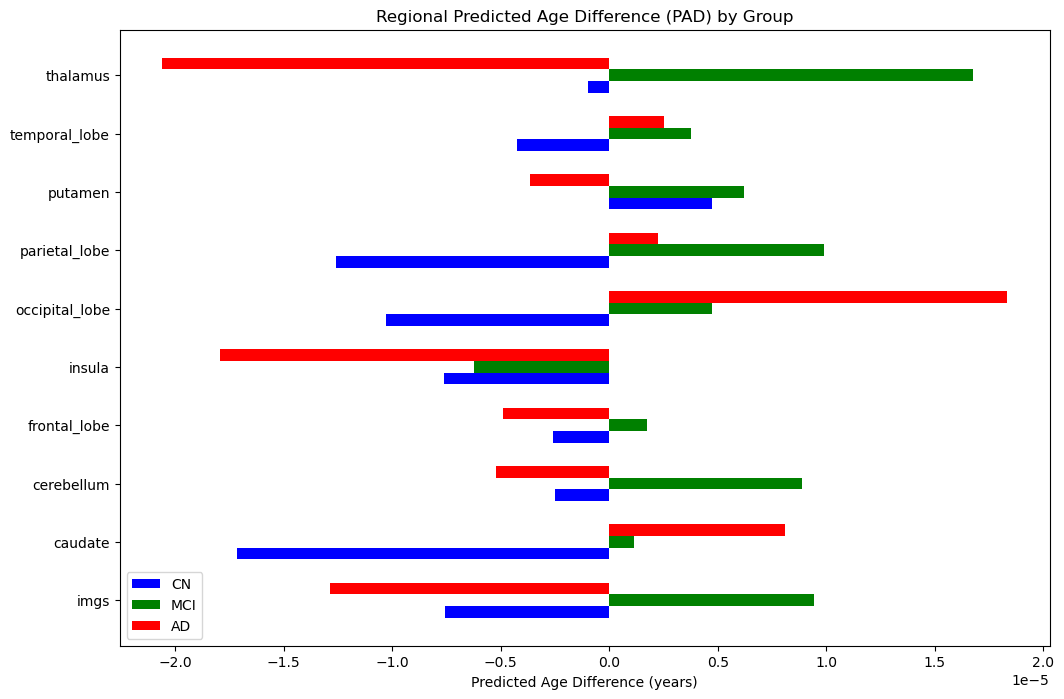

In [143]:
# 시각화
multi_group_age_diff_plot(age_diff_groups, ['CN', 'MCI', 'AD'], regions.values())

In [ ]:
age_diff_groups['CN']

In [97]:
age_diff_groups['MCI']

{'imgs': 2.2078608274301843e-05,
 'caudate': 8.572030331234581e-06,
 'cerebellum': 1.2106825065493445e-06,
 'frontal_lobe': -5.445938632265982e-06,
 'insula': 2.0287008393305267e-05,
 'occipital_lobe': 2.4887017465073704e-06,
 'parietal_lobe': 1.79765086129621e-05,
 'putamen': -3.4111069568308746e-06,
 'temporal_lobe': -2.5152459774913917e-06,
 'thalamus': 1.968843482113687e-05}

In [98]:
age_diff_groups['AD']

{'imgs': -2.758280024651978e-05,
 'caudate': -1.396808391851029e-05,
 'cerebellum': -3.6476863905926635e-05,
 'frontal_lobe': -5.7320349330314485e-06,
 'insula': 2.9107699047657682e-05,
 'occipital_lobe': 2.8543562909625753e-05,
 'parietal_lobe': -1.1782449824284873e-05,
 'putamen': -1.2767660176137843e-06,
 'temporal_lobe': 2.366894619698889e-05,
 'thalamus': -2.6404444511359487e-05}

# Age Difference Distribution

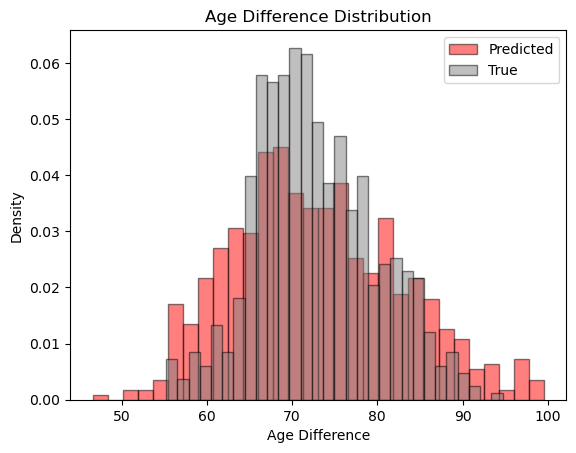

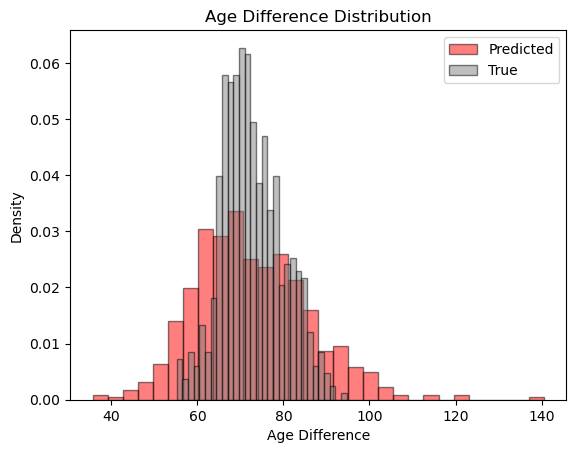

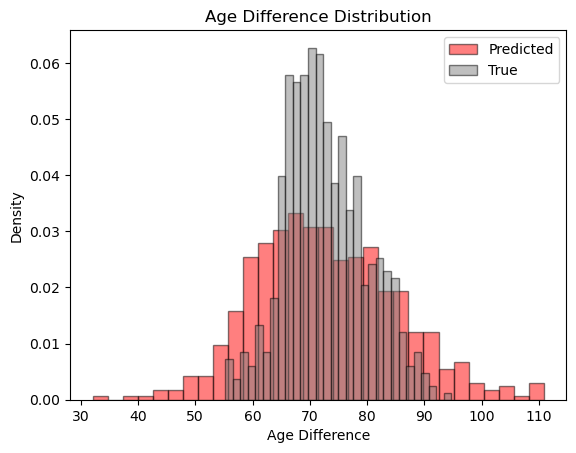

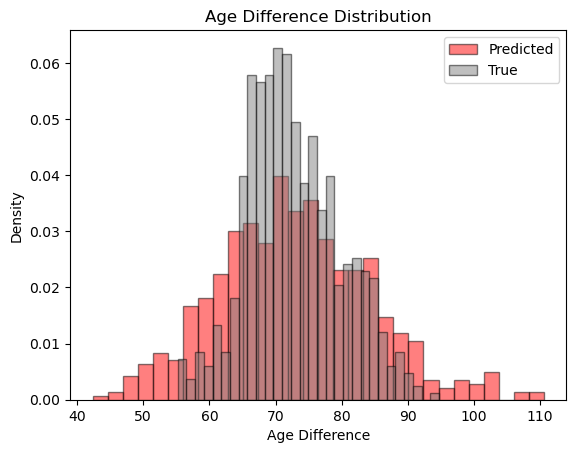

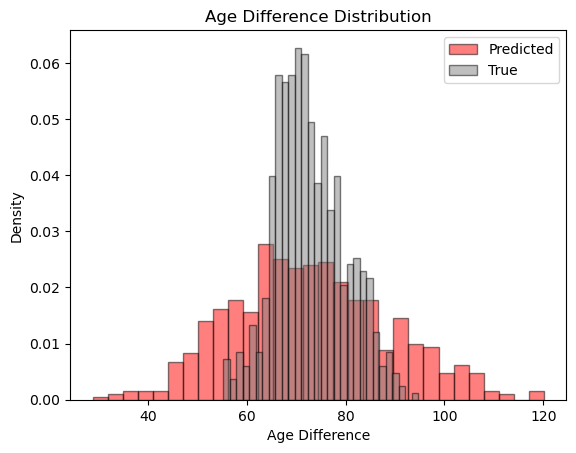

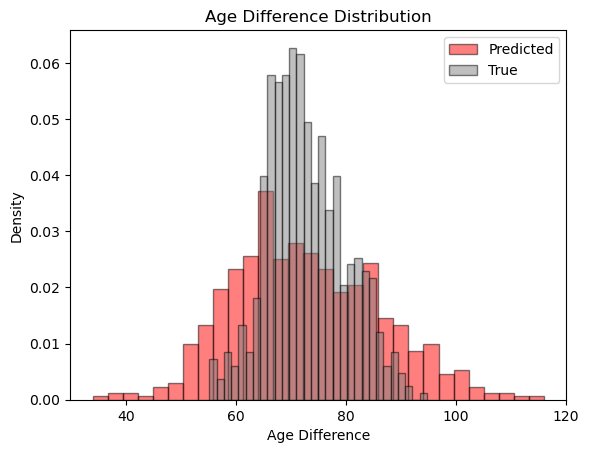

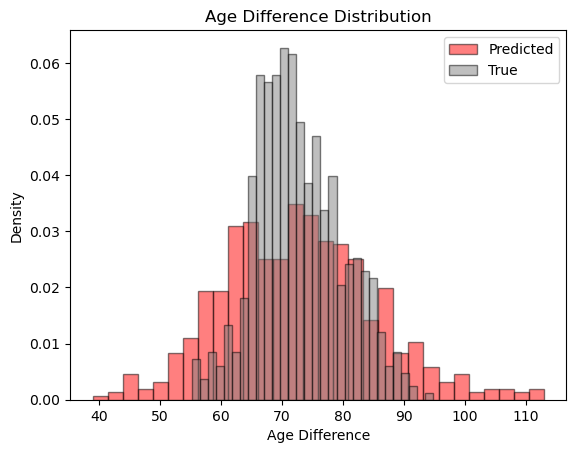

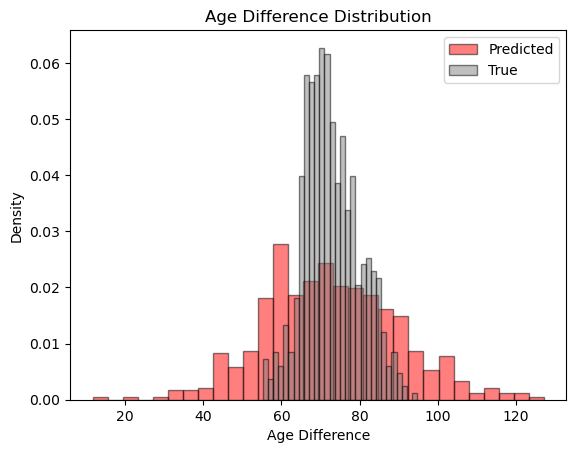

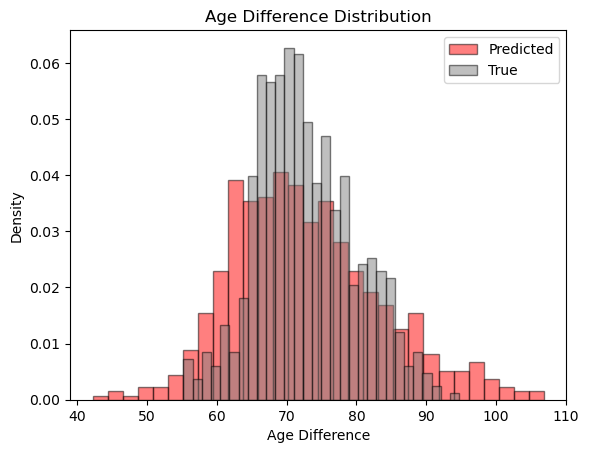

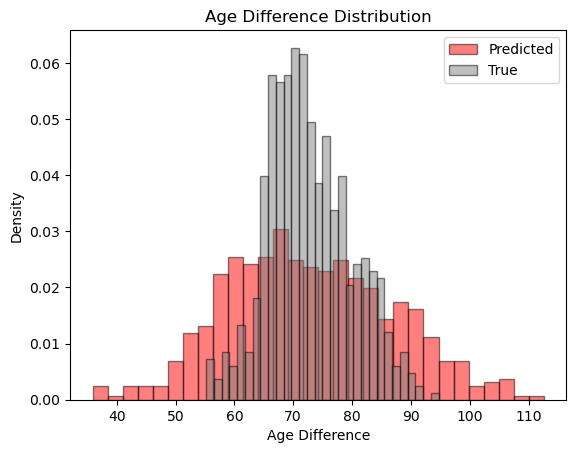

In [99]:
for key, region in regions.items():
    calculate_age_diff_dist(adni_cn_ages,region)

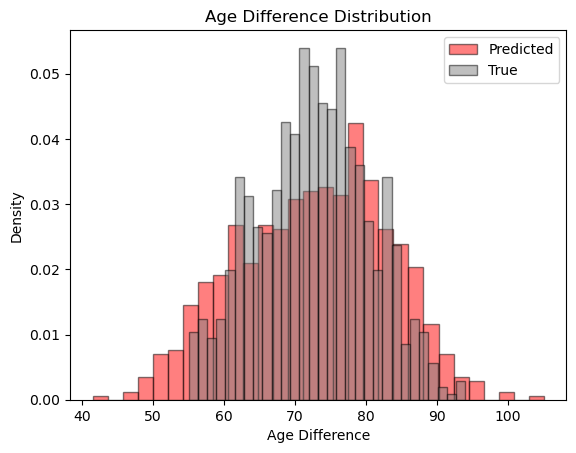

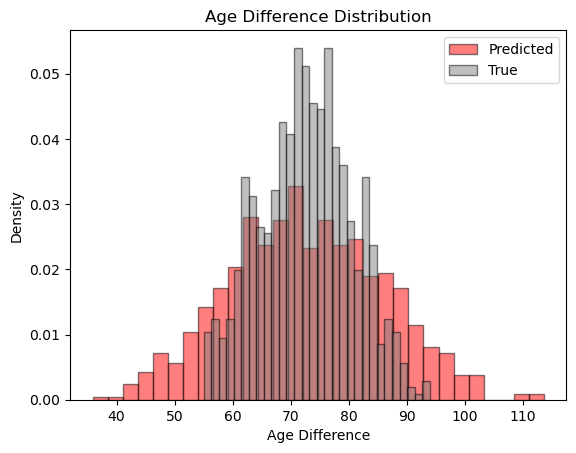

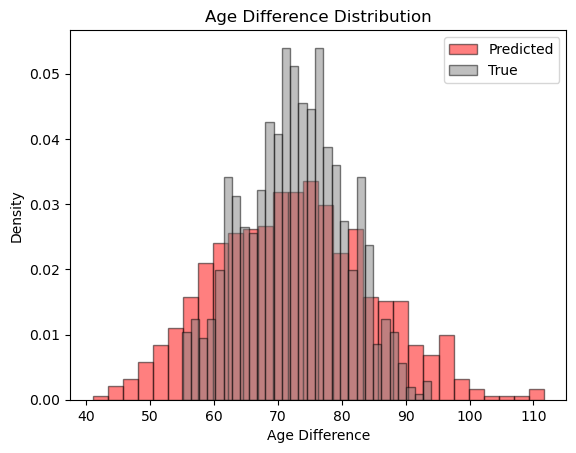

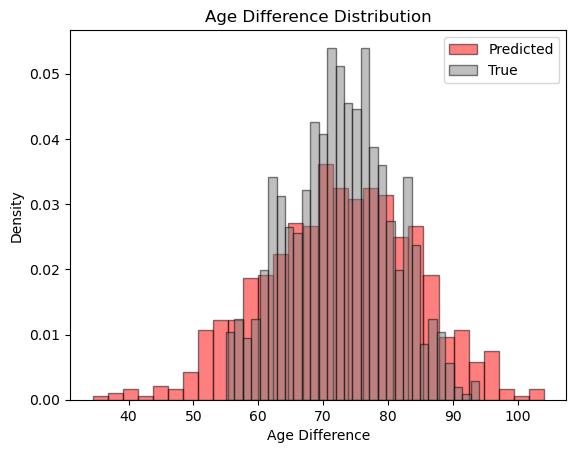

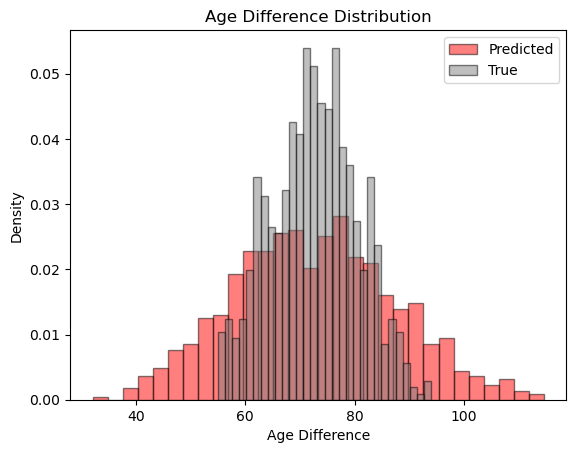

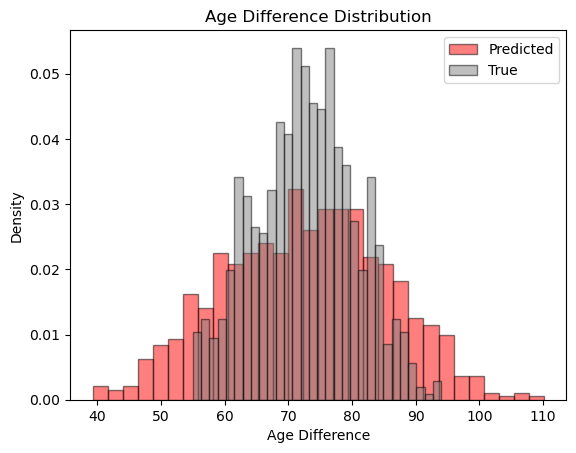

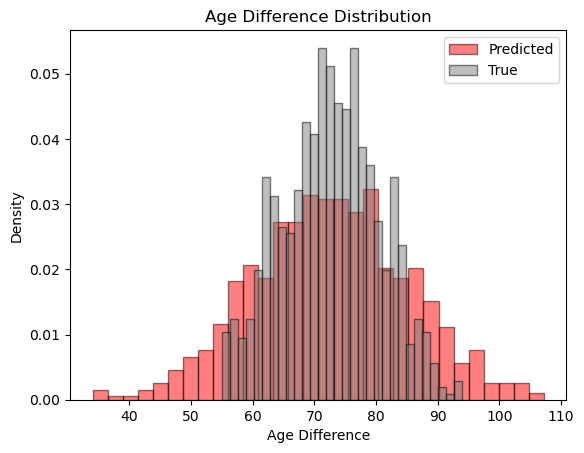

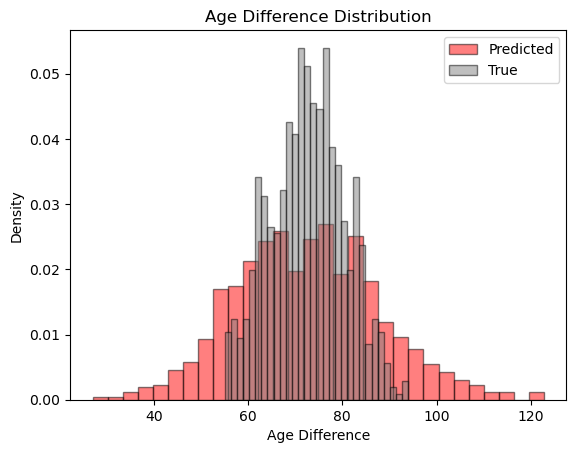

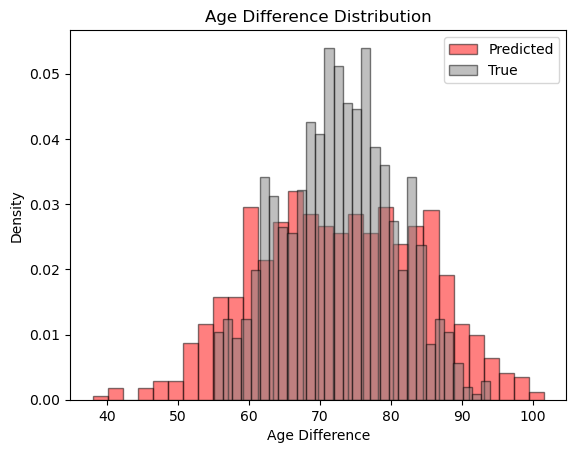

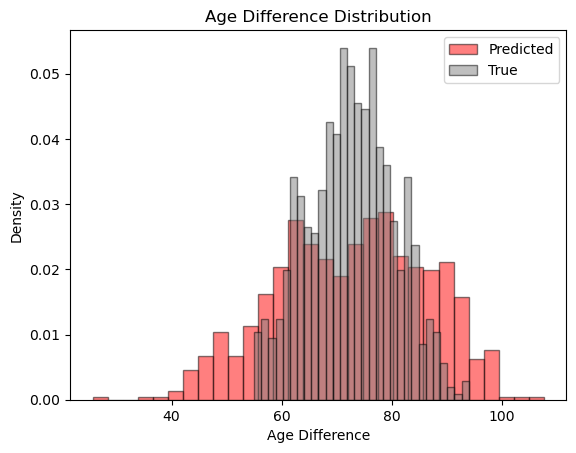

In [100]:
for key, region in regions.items():
    calculate_age_diff_dist(adni_mci_ages,region)

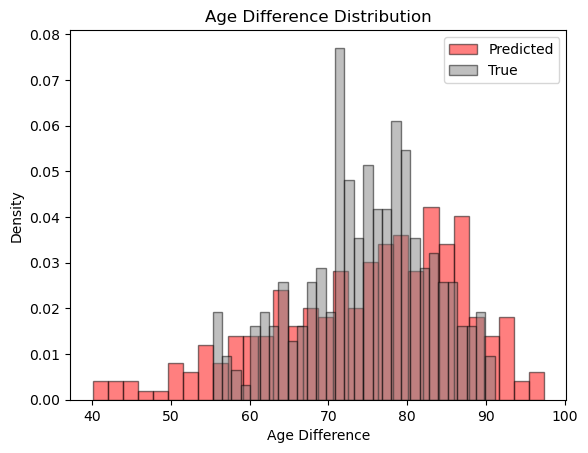

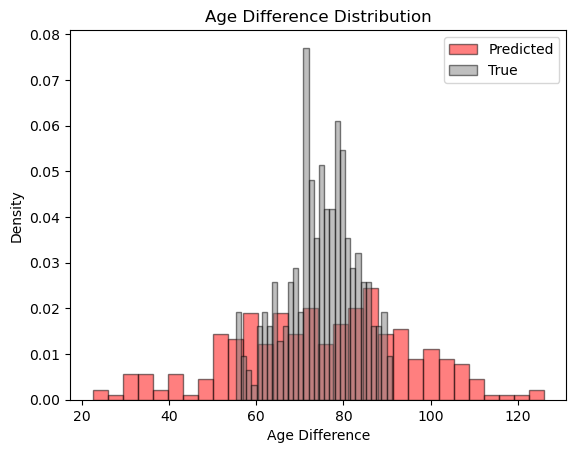

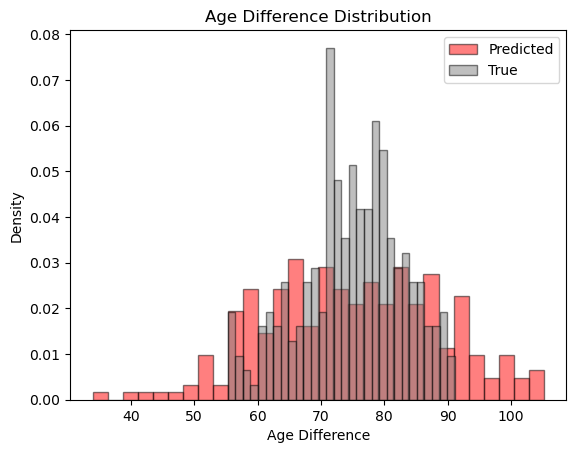

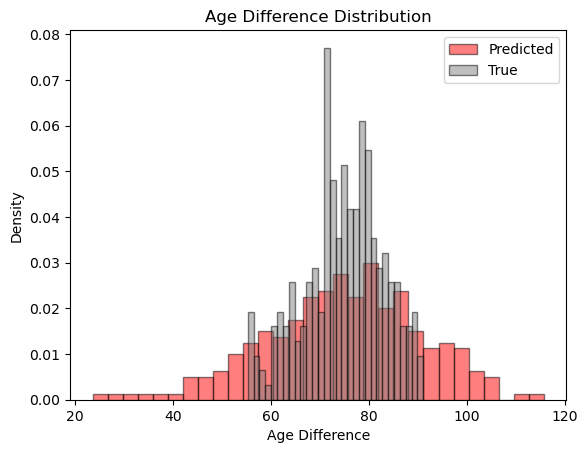

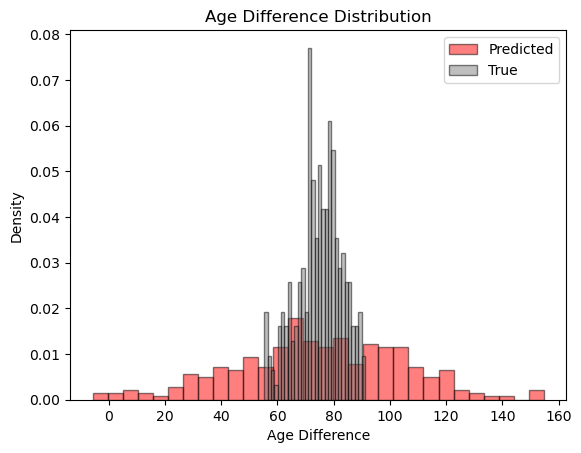

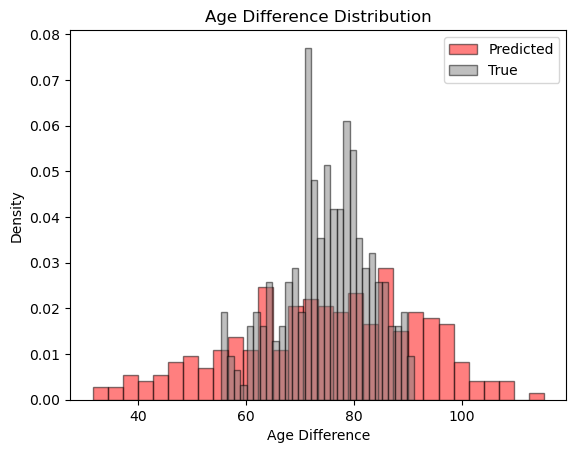

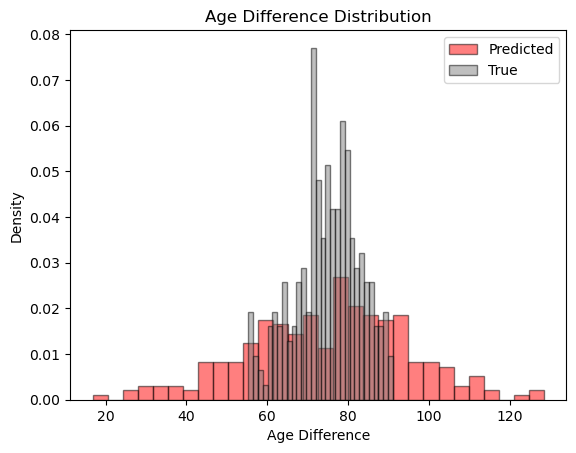

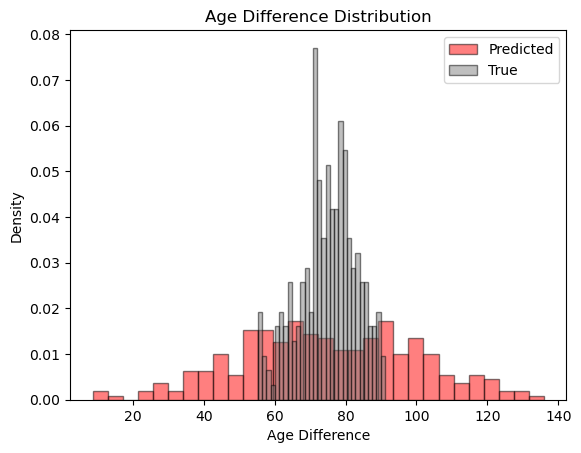

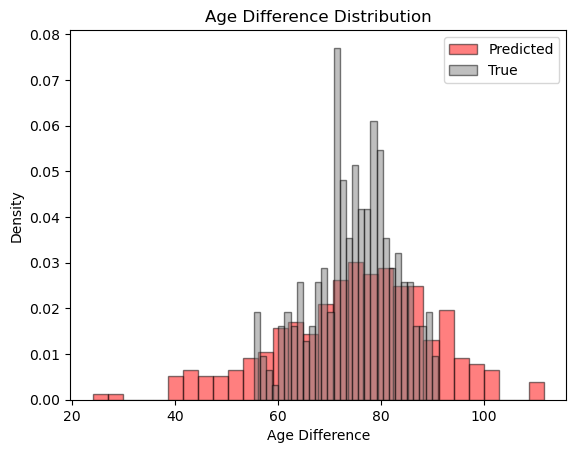

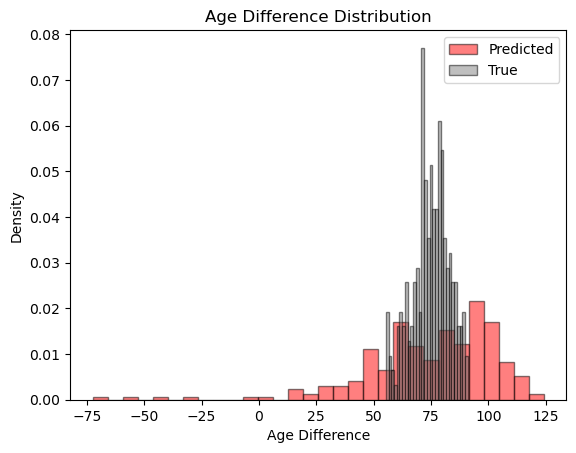

In [101]:
for key, region in regions.items():
    calculate_age_diff_dist(adni_ad_ages,region)